Pleural Effusion Classifier

In [1]:
# import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,utils,models,datasets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import imutils
from gradcam.utils import visualize_cam
from gradcam import GradCAMpp
import os, random
import os.path
import platform

print("python version:", platform.python_version())
print("torch version:", torch.__version__)
print("torch cuda:", torch.cuda.is_available())
print("torch cuda version", torch.version.cuda)
gpu=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

python version: 3.7.7
torch version: 1.6.0
torch cuda: True
torch cuda version 10.2


In [2]:
# the model
model = models.vgg19(pretrained=True)

for param in model.features.parameters():
    param.requires_grad=False

conv28 = nn.Conv2d(512, 512, 3, 1)
conv30 = nn.Conv2d(512, 512, 3, 1)
conv32 = nn.Conv2d(512, 512, 3, 1)
conv34 = nn.Conv2d(512, 512, 3, 1)

gap = nn.AdaptiveAvgPool2d((1, 1))
first_fc_layer=nn.Linear(512, 1024)
second_fc_layer=nn.Linear(1024, 1024)
last_fc_layer=nn.Linear(1024, 2)
do1=torch.nn.Dropout(p=0, inplace=False)
do2=torch.nn.Dropout(p=0, inplace=False)

model.avgpool = gap
model.classifier[0]=first_fc_layer
model.classifier[3]=second_fc_layer
model.classifier[6]=last_fc_layer
model.classifier[2]=do1
model.classifier[5]=do2

model.features[28]=conv28
model.features[30]=conv30
model.features[32]=conv32
model.features[34]=conv34

model.to(gpu)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [3]:
# # load trained model
# model.load_state_dict(torch.load(r'model/vgg19gap.pth'))

# load checkpoint 
checkpoint = torch.load(r'checkpoint/vgg19gap_lowest_val_loss_epoch_5.pth')
model.load_state_dict(checkpoint['state_dict'])
# optimizer = torch.optim.Adam(model.parameters(),lr=0)
# optimizer.load_state_dict(checkpoint['optimizer'])
# epoch = checkpoint['epoch']

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [4]:
# prepare test data
transform=transforms.Compose([
    transforms.Resize((224 ,224))
    ,transforms.ToTensor()
    ,transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_data=datasets.ImageFolder(
    root='dataset/test_set/'
    ,transform=transform
)

test_loader=torch.utils.data.DataLoader(
    test_data,
    batch_size=16
    ,shuffle=False
    ,num_workers=1
    ,pin_memory=True
)

print("Classes : ", test_data.class_to_idx)
print("Number of Test Samples : ", len(test_data))

Classes :  {'Effusion': 0, 'No Finding': 1}
Number of Test Samples :  250


In [7]:
all_preds = torch.tensor([])
all_preds = all_preds.to(gpu)

for batch in test_loader:
    images, labels = batch
    images = images.to(gpu)
    labels = labels.to(gpu)

    # predict
    model.eval()
    with torch.no_grad():
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
            )

all_preds = all_preds.cpu()
test_preds_indices = all_preds.argmax(dim=1).cpu()
test_act_labels = torch.tensor(test_data.targets)

print(test_preds_indices)
print(test_act_labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 

In [8]:
# confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cnf_matrix = confusion_matrix(test_act_labels, test_preds_indices)
print(cnf_matrix)

[[121   4]
 [  7 118]]


Text(0.5, 17.5, 'Predicted label')

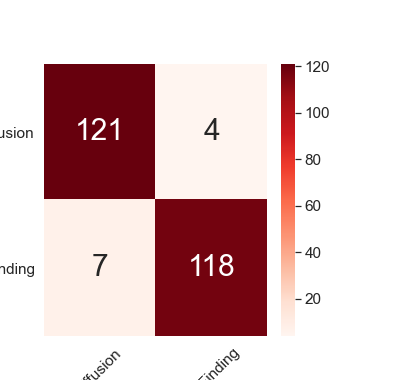

In [9]:
# plot confusion matrix with seaborn
import seaborn as sns
plt.figure(figsize=(5,5))

x_axis_labels = ['Effusion', 'No Finding']
y_axis_labels = ['Effusion', 'No Finding']

sns.set(font_scale=1.4)#for label size
sns.heatmap(cnf_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, annot_kws={"size": 30} , cmap="Reds", fmt='g')

plt.yticks(rotation=360)
plt.xticks(rotation=45)

plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig(r'graphs\cnf.png', dpi = 100)

In [10]:
# create label for data (per each class), for calssification report
class_labels = test_data.class_to_idx
class_name = list(class_labels.keys())

# classification report
print(classification_report(test_act_labels, test_preds_indices.cpu(), target_names = class_name))

              precision    recall  f1-score   support

    Effusion       0.95      0.97      0.96       125
  No Finding       0.97      0.94      0.96       125

    accuracy                           0.96       250
   macro avg       0.96      0.96      0.96       250
weighted avg       0.96      0.96      0.96       250



No Skill: ROC AUC=0.500
Model: ROC AUC=0.994


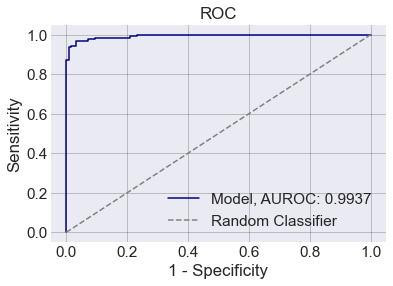

In [11]:
# roc, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

auc  = roc_auc_score(test_act_labels, test_preds_indices)
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.title('ROC')

lr_probs = all_preds[:, 1]
testy = test_act_labels
ns_probs = [0 for _ in range(len(testy))]

ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

plt.plot(lr_fpr, lr_tpr, label= 'Model, AUROC: %.4f' % lr_auc, color = 'navy')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Classifier', color = 'gray')
plt.ylabel('Sensitivity')
plt.xlabel('1 - Specificity')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)
plt.legend()
#plt.savefig(r'graphs\roc.png', dpi = 100)

Make Single Prediction (OpenCV - Grad-CAM++)

In [7]:
for i in range(3):
    
    # select random image from directory
    No_Finding = random.choice(os.listdir(r"dataset\test_set\No Finding"))
    Effusion = random.choice(os.listdir(r"dataset\test_set\Effusion"))
    image_path = random.choice([No_Finding, Effusion])

    # path of image file
    for root, dirs, files in os.walk(r'D:\Data\Documents\Rafi\Python Scripts\Pleural_Effusion_Classifier_Model_PyTorch'):
        for name in files:
            if name == image_path:
                image_path = os.path.abspath(os.path.join(root, name))

    # load image data
    loadimage = image_path

    # true label of the image
    true_label = os.path.split(os.path.dirname(loadimage))[-1]

    # function, predict
    def testimage():
        global loadimage
        model.eval()
        with torch.no_grad():
            test_image = Image.open(loadimage).convert('RGB')
            test_image = transform(test_image).float()
            #test_image = np.transpose(test_image, (1,2,0))
            test_image = test_image.unsqueeze_(0)
            test_image_n = test_image.to(gpu)
            test_image = model(test_image_n)
            test_image = F.softmax(test_image, dim=1) * 100

            if test_image[0, 0] > test_image[0, 1]:
                result = 'Effusion'
            else:
                result = 'No Finding'
            
            Effusion = test_image[0, 0]
            No_Finding = test_image[0, 1]

            return Effusion, No_Finding, result, test_image_n

    test_image = testimage()

    def testimage_prob_sorted():
        testimage_prob_sorted = {
                                test_image[0]: "Effusion", 
                                test_image[1]: "No Finding"
                                }

        testimage_prob_sorted = {v: k for k, v in sorted(testimage_prob_sorted.items(), reverse=True)}
        return testimage_prob_sorted

    testimage_prob_sorted = testimage_prob_sorted()

    # extract every single key and value on testimage_prob_sorted dictionary to its own variable
    testimage_prob_sorted_keys = list(testimage_prob_sorted.keys())
    testimage_prob_sorted_values = list(testimage_prob_sorted.values())

    prob_key_1 = testimage_prob_sorted_keys[0]
    prob_value_1 = round(testimage_prob_sorted_values[0].item(),2)

    prob_key_2 = testimage_prob_sorted_keys[1]
    prob_value_2 = round(testimage_prob_sorted_values[1].item(),2)

    # apply gradcam++
    def gradcampp_apply():
        background = Image.open(loadimage).convert('RGB')
        heatmap = test_image[3]
        gradcampp = GradCAMpp(model, model.features[31])
        heatmap, _ = gradcampp(heatmap)
        heatmap, _ = visualize_cam(heatmap, test_image[3])
        heatmap = transforms.ToPILImage(mode='RGB')(heatmap)
        heatmap = heatmap.resize((1024, 1024), Image.NEAREST)
        return heatmap
    
    background =  cv2.imread(loadimage)
    heatmap =  gradcampp_apply()
    heatbox = cv2.addWeighted(np.array(background), 0.7, np.array(heatmap), 0.6, 0)
    output = np.hstack([background, heatbox])
    output = imutils.resize(output, height=500)
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

    # OpenCV

    # Write some Text
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 1
    lineType               = 2

    result = testimage()[2]

    def fontColor():
        if true_label == result:
                fontColor  = (0, 255, 0)
        else:
            fontColor  = (0, 0, 255)
        return fontColor

    fontColor = fontColor()

    true_label_text_pos = (10,30)
    predicted_label_text_pos = (10,60)
    predicted_proba_text_pos_1 = (10,90)
    predicted_proba_text_pos_2 = (10,120)
    # get file name
    file_name = os.path.basename(image_path)
    file_name_pos = (10,150)


    cv2.putText(output,'True Label : ' + true_label, 
        true_label_text_pos, 
        font, 
        fontScale,
        fontColor,
        lineType)

    cv2.putText(output,'Predicted Label : ', 
        predicted_label_text_pos, 
        font, 
        fontScale,
        fontColor,
        lineType)

    cv2.putText(output,prob_key_1 + " - " + str(prob_value_1) + '%', 
        predicted_proba_text_pos_1, 
        font, 
        fontScale,
        fontColor,
        lineType)

    cv2.putText(output,prob_key_2 + " - " + str(prob_value_2) + '%', 
        predicted_proba_text_pos_2, 
        font, 
        fontScale,
        fontColor,
        lineType)

    cv2.putText(output,'File Name : ' + file_name, 
        file_name_pos,       
        font, 
        fontScale,
        fontColor,
        lineType)

    #Display the image
    cv2.imshow("Lung Diseases Classifier",output)
    #cv2.imwrite(r"graphs\test_{}.png".format(i+1), output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Detection with Bounding Box (Imperfect)

In [8]:
for i in range(3):
    
    # select random image from directory
    No_Finding = random.choice(os.listdir(r"dataset\test_set\No Finding"))
    Effusion = random.choice(os.listdir(r"dataset\test_set\Effusion"))
    image_path = random.choice([No_Finding, Effusion])

    # path of image file
    for root, dirs, files in os.walk(r'D:\Data\Documents\Rafi\Python Scripts\Pleural_Effusion_Classifier_Model_PyTorch'):
        for name in files:
            if name == image_path:
                image_path = os.path.abspath(os.path.join(root, name))

    # load image data
    loadimage = image_path

    # true label of the image
    true_label = os.path.split(os.path.dirname(loadimage))[-1]

    # function, predict
    def testimage():
        global loadimage
        model.eval()
        with torch.no_grad():
            test_image = Image.open(loadimage).convert('RGB')
            test_image = transform(test_image).float()
            #test_image = np.transpose(test_image, (1,2,0))
            test_image = test_image.unsqueeze_(0)
            test_image_n = test_image.to(gpu)
            test_image = model(test_image_n)
            test_image = F.softmax(test_image, dim=1) * 100

            if test_image[0, 0] > test_image[0, 1]:
                result = 'Effusion'
            else:
                result = 'No Finding'
            
            Effusion = test_image[0, 0]
            No_Finding = test_image[0, 1]

            return Effusion, No_Finding, result, test_image_n

    test_image = testimage()

    def testimage_prob_sorted():
        testimage_prob_sorted = {
                                test_image[0]: "Effusion", 
                                test_image[1]: "No Finding"
                                }

        testimage_prob_sorted = {v: k for k, v in sorted(testimage_prob_sorted.items(), reverse=True)}
        return testimage_prob_sorted

    testimage_prob_sorted = testimage_prob_sorted()

    # extract every single key and value on testimage_prob_sorted dictionary to its own variable
    testimage_prob_sorted_keys = list(testimage_prob_sorted.keys())
    testimage_prob_sorted_values = list(testimage_prob_sorted.values())

    prob_key_1 = testimage_prob_sorted_keys[0]
    prob_value_1 = round(testimage_prob_sorted_values[0].item(),2)

    prob_key_2 = testimage_prob_sorted_keys[1]
    prob_value_2 = round(testimage_prob_sorted_values[1].item(),2)

    # apply gradcam++
    def gradcampp_apply():
        background = Image.open(loadimage).convert('RGB')
        heatmap = test_image[3]
        gradcampp = GradCAMpp(model, model.features[31])
        heatmap, _ = gradcampp(heatmap)
        heatmap, _ = visualize_cam(heatmap, test_image[3])
        heatmap = transforms.ToPILImage(mode='RGB')(heatmap)
        heatmap = heatmap.resize((1024, 1024), Image.NEAREST)
        return heatmap

    # bounding box
    orig = cv2.imread(loadimage)
    heatmap = gradcampp_apply()
    gray = cv2.cvtColor(np.array(heatmap), cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)[0]

    try:
        contours = [contours[1], contours[2], contours[3]]
        for c in contours[0]:
            x,y,w,h = cv2.boundingRect(contours[0])
            cv2.rectangle(orig, (x, y), (x + w, y + h), (0,255,0), 1)
        for c in contours[1]:
            x,y,w,h = cv2.boundingRect(contours[1])
            cv2.rectangle(orig, (x, y), (x + w, y + h), (0,255,0), 1)
        for c in contours[2]:
            x,y,w,h = cv2.boundingRect(contours[1])
            cv2.rectangle(orig, (x, y), (x + w, y + h), (0,255,0), 1)
    except:
        pass

    try:
        contours = [contours[1], contours[2]]
        for c in contours[0]:
            x,y,w,h = cv2.boundingRect(contours[0])
            cv2.rectangle(orig, (x, y), (x + w, y + h), (0,255,0), 2)
        for c in contours[1]:
            x,y,w,h = cv2.boundingRect(contours[1])
            cv2.rectangle(orig, (x, y), (x + w, y + h), (0,255,0), 2)    
    except:
        pass

    try:
        contours = contours[1]
        for c in contours:
            x,y,w,h = cv2.boundingRect(contours)
            cv2.rectangle(orig, (x, y), (x + w, y + h), (0,255,0), 2)
    except:
        pass

    contours = contours[0]
    for c in contours:
        x,y,w,h = cv2.boundingRect(contours)
        cv2.rectangle(orig, (x, y), (x + w, y + h), (0,255,0), 2)

    heatbox = cv2.addWeighted(orig, 0.7, np.array(heatmap), 0.6, 0)
    output = np.hstack([orig, heatbox])
    output = imutils.resize(output, height=500)
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

    # OpenCV

    # Write some Text
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 1
    lineType               = 2

    result = testimage()[2]

    def fontColor():
        if true_label == result:
                fontColor  = (0, 255, 0)
        else:
            fontColor  = (0, 0, 255)
        return fontColor

    fontColor = fontColor()

    true_label_text_pos = (10,30)
    predicted_label_text_pos = (10,60)
    predicted_proba_text_pos_1 = (10,90)
    predicted_proba_text_pos_2 = (10,120)
    # get file name
    file_name = os.path.basename(image_path)
    file_name_pos = (10,150)


    cv2.putText(output,'True Label : ' + true_label, 
        true_label_text_pos, 
        font, 
        fontScale,
        fontColor,
        lineType)

    cv2.putText(output,'Predicted Label : ', 
        predicted_label_text_pos, 
        font, 
        fontScale,
        fontColor,
        lineType)

    cv2.putText(output,prob_key_1 + " - " + str(prob_value_1) + '%', 
        predicted_proba_text_pos_1, 
        font, 
        fontScale,
        fontColor,
        lineType)

    cv2.putText(output,prob_key_2 + " - " + str(prob_value_2) + '%', 
        predicted_proba_text_pos_2, 
        font, 
        fontScale,
        fontColor,
        lineType)

    cv2.putText(output,'File Name : ' + file_name, 
        file_name_pos,       
        font, 
        fontScale,
        fontColor,
        lineType)

    #Display the image
    cv2.imshow("Lung Diseases Classifier",output)
    #cv2.imwrite(r"graphs\test_{}.png".format(i+1), output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()